In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate
import pandas as pd
%matplotlib inline

In /Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/anasofiauzsoy/anaconda

In [53]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize']    = 18.
mpl.rcParams['ytick.labelsize']    = 18.
mpl.rcParams['xtick.top']          = True
mpl.rcParams['ytick.right']        = True
mpl.rcParams['xtick.direction']    = 'in'
mpl.rcParams['ytick.direction']    = 'in'
mpl.rcParams['xtick.major.size']   = 7.
mpl.rcParams['xtick.minor.size']   = 4.
mpl.rcParams['ytick.major.size']   = 7.
mpl.rcParams['ytick.minor.size']   = 4.
mpl.rcParams['xtick.major.pad']    = 10
mpl.rcParams['ytick.major.pad']    = 10

mpl.rcParams['legend.fontsize']    = 24.
mpl.rcParams['legend.frameon']     = False

mpl.rcParams['axes.labelsize']     = 24.
mpl.rcParams['axes.titlesize']     = 24.
mpl.rcParams['axes.titlepad']      = 10

mpl.rcParams['savefig.directory']  = ''
mpl.rcParams['text.usetex']        = False
mpl.rcParams['font.family']        = 'serif'


In [3]:
#kepids, koi, per = np.loadtxt("USP_planet_info.txt")
df = pd.read_csv("isochrones_input.csv")
kepids = df.kepid.values
koi = df.koi.values
per = df.per.values
rad_arrays= np.loadtxt("planet_radius_samples111820.txt")

In [4]:
radiisamples = rad_arrays.flatten()

In [5]:
mean_planet_radii = [np.percentile(i, 50) for i in rad_arrays]
radiierrup = [np.percentile(i, 15.85) for i in rad_arrays]
radiierrdown = [np.percentile(i, 84.15) for i in rad_arrays]
periodsamples = [per[i//1000] for i in range(len(radiisamples))]

In [6]:
np.max(mean_planet_radii)

1.919746736442197

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if __name__ == '__main__':
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if __name__ == '__main__':


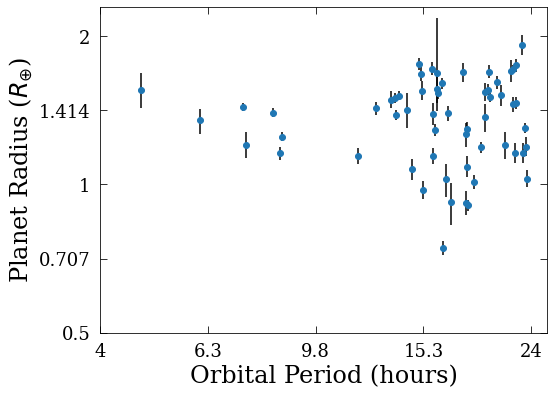

In [7]:
down = [i - j for i,j in zip(mean_planet_radii, radiierrup)]
up = [i - j for i,j in zip(radiierrdown, mean_planet_radii)]

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]


g = plt.figure(figsize = (8,6))
plt.loglog(per*24,mean_planet_radii, 'o', basex = (6**0.25), basey = np.sqrt(2))
plt.errorbar(per*24,mean_planet_radii, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(radbins[:-2], [0.5,0.707,1,1.414,2])
plt.xticks(perbins,[4,6.3,9.8,15.3,24])
plt.xlabel("Orbital Period (hours)")
plt.ylabel("Planet Radius ($R_{ \oplus}$)")
##plt.title("Planet Radius vs. Orbital Period")
g.savefig("PosterFig2.pdf", bbox_inches = "tight")
plt.show()

## Spherical integration

In [18]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 64)

P_max_hat = np.concatenate((np.logspace(0., 0.01, 10), np.logspace(0.011, 2., 54)))

#P_max_hat = np.logspace(0., 2., 64)

cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [19]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(len(P_max_hat)):
        
        if i == 0 or j != 0:


            Pcmb = P_cmb[i]
            eos = IronSilicateEOS(Pcmb, P_max_hat[j])
            Pc = eos.P_max
            Pcarr.append(Pc)

            def rho(P):
                return eos.eqnOfState(P)


            m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
            P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure

             ## change of variables where q = ln(P)
            def dmdq(q, m, r):
                P = np.exp(q)
                g = (G * m) / (r**2)
                return (-4 * P * np.pi * (r**2)) / g

            def drdq(q, m, r):
                P = np.exp(q)
                g = (G * m) / (r**2)
                return -P / (rho(P) * g)

            def fun(q, x):
                m, r = x
                return dmdq(q, m, r), drdq(q, m, r)

            q0 = np.log(P0)

            sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

            ## LSODA is the only integration method that works for this order of magnitude

            pressure = np.exp(sol.t)
            masses = sol.y[0]
            radii = sol.y[1]

            if i == 25 and j == 25:
                 pre = np.exp(sol.t)
                 mas = sol.y[0]
                 rad = sol.y[1]

            #print(i,j)

            # interpolate masses
            s = interpolate.interp1d(pressure, masses)
            coremass = s(Pcmb) # mass of core
            totalmass = s(1) # total planet mass
            cmf = coremass / totalmass # core mass fraction
            cmfarray[i][j] = cmf
            planetmass[i][j] = totalmass / Emass # in Earth masses

            # interpolate radii
            r = interpolate.interp1d(pressure, radii)
            corerad = r(Pcmb) # radius of core
            totalrad = r(1) # total radius
            crf = corerad / totalrad # core radius fraction
            crfarray[i][j] = crf
            planetrad[i][j] = totalrad / Erad # in Earth radii


In [21]:
planetrad

array([[0.04125761, 0.04124317, 0.04122724, ..., 0.14408745, 0.15001173,
        0.15609901],
       [0.        , 0.04601715, 0.04599848, ..., 0.15976367, 0.16626493,
        0.17293316],
       [0.        , 0.05134254, 0.05132213, ..., 0.17712115, 0.18404836,
        0.19149243],
       ...,
       [0.        , 3.27501239, 3.27495869, ..., 2.76116223, 2.76294792,
        2.76457424],
       [0.        , 3.31319986, 3.31315981, ..., 2.77523138, 2.77617525,
        2.7777994 ],
       [0.        , 3.34644452, 3.34647647, ..., 2.78839805, 2.78972451,
        2.79081833]])

In [22]:
cmfarray

array([[4.61288675e-20, 1.95129727e-05, 5.53731908e-05, ...,
        9.81555319e-01, 9.83063992e-01, 9.84472740e-01],
       [0.00000000e+00, 1.95124173e-05, 5.53586710e-05, ...,
        9.81495248e-01, 9.83002260e-01, 9.84410831e-01],
       [0.00000000e+00, 1.95115532e-05, 5.53561514e-05, ...,
        9.81349926e-01, 9.82930368e-01, 9.84289029e-01],
       ...,
       [0.00000000e+00, 3.32973468e-05, 9.42134177e-05, ...,
        9.55112628e-01, 9.58460716e-01, 9.61573213e-01],
       [0.00000000e+00, 3.39325522e-05, 9.60035082e-05, ...,
        9.54997462e-01, 9.58364829e-01, 9.61442604e-01],
       [0.00000000e+00, 3.45945042e-05, 9.78748193e-05, ...,
        9.54820680e-01, 9.58133393e-01, 9.61215728e-01]])

Set up and flatten arrays for interpolation

In [23]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

In [24]:
def get_mass(radius, cmf):
    return getmass((getpcmb(radius, cmf), getpmaxhat(radius, cmf)))

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [25]:
earth_mass_grid = np.zeros_like(cmfarray)
merc_mass_grid = np.zeros_like(cmfarray)
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        try:
            earth_mass_grid[i][j] = get_mass(planetrad[i][j], 0.33)
            merc_mass_grid[i][j] = get_mass(planetrad[i][j], 0.7)
        except:
            earth_mass_grid[i][j] = 0
            merc_mass_grid[i][j] = 0
            
earthmax = np.nanmax(earth_mass_grid)
mercmax = np.nanmax(merc_mass_grid)

In [26]:
def get_max_mass_cmf(cmf):
    mass_grid = np.zeros_like(cmfarray)
    for i in range(len(P_cmb)):
        for j in range(len(P_cmb)):
            try:
                mass_grid[i][j] = get_mass(planetrad[i][j], cmf)
            except:
                mass_grid[i][j] = 0
                mass_grid[i][j] = 0
    return np.max(mass_grid)

In [27]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(get_mass(radsample, 0.33))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(earthmax)
        i = i + 1

print("Mercury")
count = 0
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(get_mass(radsample, 0.7))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        count += 1
        mercurymasssamples.append(mercmax)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(get_mass(radsample, randomcmf))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        if randomcmf < 0.1:
            randmasssamples.append(np.nan)
        else:
            max_mass = get_max_mass_cmf(randomcmf)
            randmasssamples.append(max_mass)
            print("max mass: ", max_mass)
        i = i + 1
            

print(count)

could not interpolate for sample 29845
Mercury
could not interpolate for sample 29191
could not interpolate for sample 29563
could not interpolate for sample 29671
could not interpolate for sample 29845
4


In [28]:
radiisamples[6282]

1.4315580421048166

In [29]:
np.min(cmfarray)

0.0

In [30]:
np.where(radiisamples > 2.8)

(array([29169, 29191, 29402, 29460, 29532, 29563, 29671, 29845, 29880]),)

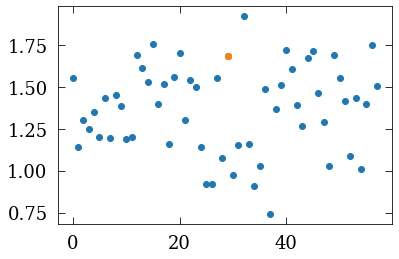

In [31]:
plt.plot(mean_planet_radii, 'o')
plt.plot(29, mean_planet_radii[29], 'o')

Okay, so there's one planet(index 33) that has some issues (it's the biggest radius one).

In [32]:
meanearthmasses = []
eartherr = []
eartherrup = []
eartherrdown = []

meanmercmasses = []
mercerr = []
mercerrup = []
mercerrdown = []

meanrandmasses = []
randerr = []
randerrup = []
randerrdown = []

earth_num_samples = []
merc_num_samples = []
rand_num_samples = []


for i in range(0, len(per)):
    earth = earthmasssamples[(1000*i) : (1000*(i+1))]
    merc = mercurymasssamples[(1000*i) : (1000*(i+1))]
    rand = randmasssamples[(1000*i) : (1000*(i+1))]
    meanearthmasses.append(np.percentile(earth, 50))
    eartherr.append(np.std(earth))
    eartherrup.append(np.percentile(earth, 15.85))
    eartherrdown.append(np.percentile(earth, 84.15))
    meanmercmasses.append(np.percentile(merc, 50))
    mercerr.append(np.std(merc))
    mercerrup.append(np.percentile(merc, 15.85))
    mercerrdown.append(np.percentile(merc, 84.15))
    meanrandmasses.append(np.percentile(rand, 50))
    randerr.append(np.std(rand))
    randerrup.append(np.percentile(rand, 15.85))
    randerrdown.append(np.percentile(rand, 84.15))

np.savetxt("earthlike_masses.txt", (meanearthmasses, eartherrup, eartherrdown, eartherr), header = "median, errup, errdown, stdev" )
np.savetxt("merclike_masses.txt", (meanmercmasses, mercerrup, mercerrdown, mercerr), header = "median, errup, errdown, stdev" )
np.savetxt("randlike_masses.txt", (meanrandmasses, randerrup, randerrdown, randerr), header = "median, errup, errdown, stdev" )

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


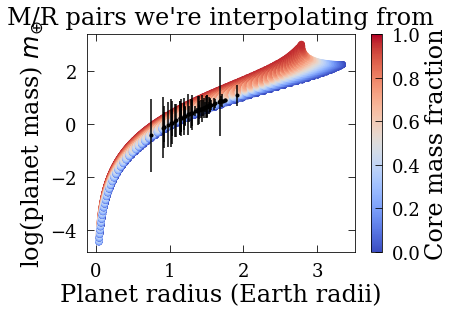

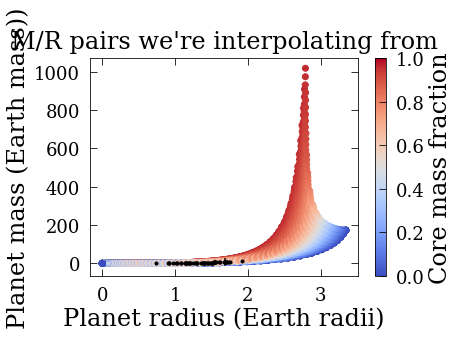

In [33]:
q = plt.figure()
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), np.log10(planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
plt.plot(mean_planet_radii, np.log10(meanearthmasses),'k.')
plt.errorbar(mean_planet_radii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(planet mass) $m_{\oplus}$")
plt.title("M/R pairs we're interpolating from")
q.savefig("darkplot.jpg", bbox_inches = "tight")
plt.show()


cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), (planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
plt.plot(mean_planet_radii, (meanearthmasses),'k.')
plt.errorbar(mean_planet_radii, (meanearthmasses),ls= 'none',yerr = (eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

In [34]:
adivr = df.adivr.values
numstars = df.numstars.values

In [35]:
# kepid = []
# koi = []
# adivr = []
# per = []
# starrad = []
# pradii = []
# numstars = []


# with open('USPHostProperties.csv') as File:
#      reader = csv.reader(File, delimiter=',')
#      rownum = 0
#      for row in reader:
#          if rownum > 0:
#              kepid.append(int(row[0]))
#              koi.append(int(row[1]))
#              adivr.append(float(row[2]))
#              per.append(float(row[3]))
#              starrad.append(float(row[11]))
#              pradii.append(float(row[12]))
#              numstars.append(float(row[13]))
#          rownum += 1

# falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

# todelete = []
# for j in range(0,len(falsepositives)):
#     for i in range(0, len(kepid)):
#         if kepid[i] == falsepositives[j]:
#             todelete.append(i)
            
# todelete.reverse()
# for k in todelete:
#     del kepid[k]
#     del koi[k]
#     del per[k]
#     del adivr[k]
#     del numstars[k]
    
# adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
# per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
# numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
# print(len(per))
# print(len(numstars))

In [36]:
len(numstars)

58

In [37]:
periodsamples = [per[i//1000] for i,j in enumerate(radiisamples)]

Okay, now we're going to do the occurrence rate and mass distribution calculations.

[ 1.91223183  0.24430138  0.31521574  0.18082561  0.65334332  0.46806731
  0.33755807  0.33171438  0.52924227  0.2888088   0.20111564  0.49803575
  1.3286261   0.73544936  0.53133999  1.12273412  0.43550443  0.90486139
  0.32001352  1.69224451  1.61103684  0.22595816  0.84454326  0.40852096
  0.23668017  0.2920004   0.16869032  0.96930347  0.24480454 13.74163521
  0.15548766  0.32225807  2.74022753  0.19003881  0.07445642  0.31380831
  0.7139416   0.04408148  0.8749851   0.42602609  0.97061597  0.6163623
  0.67890949  0.49251596  1.01362642  0.59392424  0.42282404  0.27246073
  0.18017207  0.96348701  0.54289692  1.26002035  0.26706837  0.4566522
  0.13547414  0.30662948  1.08515446  0.37794056]


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]


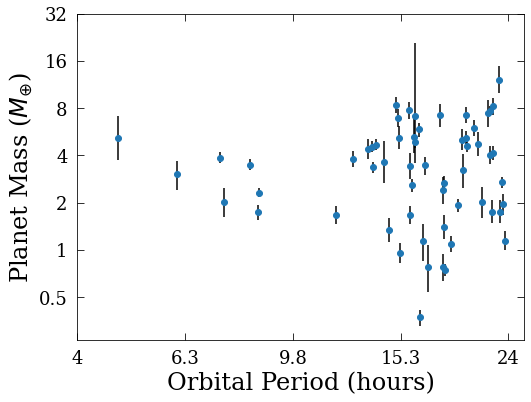

In [39]:
h = plt.figure(figsize = (8,6))
#         meanearthmasses.append(np.percentile(list1, 50))
#         eartherr.append(np.std(list1))
#         eartherrup.append(np.percentile(list1, 15.85))
#         eartherrdown.append(np.percentile(list1, 84.15))
eartherrup = np.array(eartherrup)
eartherrdown = np.array(eartherrdown)
meanearthmasses= np.array(meanearthmasses)

massbins = [0.5,1,2,4,8,16,32]

print(eartherrdown - meanearthmasses)
plt.loglog(np.array(per) * 24,meanearthmasses, 'o', basex = (6**0.25), basey = np.sqrt(2))
plt.errorbar(np.array(per) * 24,meanearthmasses, yerr = [meanearthmasses - eartherrup, eartherrdown - meanearthmasses], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32])
plt.xticks(perbins,[4,6.3,9.8,15.3,24])
plt.xlabel("Orbital Period (hours)")
plt.ylabel("Planet Mass ($M_{ \oplus}$)")
h.savefig("PosterFig4.pdf", bbox_inches = "tight")
plt.show()

In [40]:
(meanearthmasses < 5).sum()

41

## Radius distribution / Occurrence rates

In [41]:
import seaborn as sns

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
radbinsflip = np.flip(radbins,0) ## makes orientation correct on y axis

perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]
array = np.zeros((len(radbins)-1,len(perbins)-1))
scaledarray = np.zeros((len(radbins)-1,len(perbins)-1))
freqarray = np.zeros((len(radbins)-1,len(perbins)-1))

## calculates occurrence rate contribution for each planet sample
f = [(adivr[i]/numstars[i]) for i in range(0,len(kepids))]
kepid2 = []

In [42]:
persampleshours = [i * 24 for i in periodsamples]
contribs2 = [1/1000 for i,j in enumerate(radiisamples)]

def occur_freq_transit(masssamples, persampleshours, massbins, perbins):
    contribs = [(f[i//1000])/1000 for i,j in enumerate(masssamples)]
    contribs2 = [1/1000 for i,j in enumerate(masssamples)]
    occur = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)
    freq = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
    transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
    transit = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                                       weights = transit_contribs)[0], 0)
    return occur, freq, transit

occur, freq, transit_array = occur_freq_transit(radiisamples, persampleshours, radbins, perbins)
# freq = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], weights = contribs2)[0], 0)
# #print(np.transpose(np.flip(freq, 1)))
print("Frequency array: \n", freq)

# ## we should divide the contributions by 1000, because 1000 samples per planet
# ## but then we just multiply by 1000 again because per 1000 stars
# contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
# occur = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
#                                weights = contribs)[0], 0)
print("Occurrence rate array: (per thousand stars) \n", occur * 1000)

# ## we divide transit contributions by 1000 because 1000 planets per star
# transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
# transit_array = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
print("Transit array: \n", transit_array)

Frequency array: 
 [[0.0000e+00 0.0000e+00 0.0000e+00 9.0000e-03]
 [0.0000e+00 0.0000e+00 0.0000e+00 4.3100e-01]
 [1.0420e+00 1.0810e+00 7.1730e+00 1.7951e+01]
 [9.5800e-01 3.9180e+00 4.0160e+00 1.5798e+01]
 [0.0000e+00 1.0000e-03 8.1100e-01 4.7050e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.0600e-01]]
Occurrence rate array: (per thousand stars) 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.14087755e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.37337930e-02]
 [4.48389677e-02 3.14675402e-02 4.03486505e-01 1.09430343e+00]
 [4.18939346e-02 1.87648263e-01 2.83351804e-01 1.50926552e+00]
 [0.00000000e+00 7.89263808e-05 7.95621557e-02 1.05411230e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.79181302e-02]]
Transit array: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.89700279e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.27709567e-06]
 [1.28774568e-05 1.20940358e-05 8.30737811e-05 2.31145222e-04]
 [1.13486227e-05 5.15531028e-05 6.57255825e-05 3.09218848e-04]
 [0.

We want to calculate the 68.3% Wilson confidence interval.

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [43]:
z = 1
n = freq / transit_array

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [44]:
m = 500
pp = 421/500

z95 = 1.96
root = ((pp * (1-pp)) / m+ (z95**2)/(4*(m**2)))**0.5
denom = 1 + (z95**2)/m
high = (pp + (z95**2)/(2*m) + z95*root)/denom
low = (pp + (z95**2)/(2*m) - z95*root)/denom
print(high, low)


0.8713477936271825 0.8074369672976796


In [45]:
def occur_uncert(occur, numplanets, transit, z = 1):
    upper = np.zeros_like(occur)
    lower = np.zeros_like(occur)
    n = numplanets / transit
    for i in range(len(occur)):
        for j in range(len(occur[0])):
            if np.isnan(n[i][j]) == False:
                p = transit[i][j]

                root = (((p * (1-p)) / n[i][j]) + (z**2)/(4*(n[i][j]**2)))**0.5
                denom = 1 + (z**2)/n[i][j]
                high = (p + (z**2)/(2*n[i][j]) + z*root)/denom
                low = (p + (z**2)/(2*n[i][j]) - z*root)/denom
                upper[i][j] = (occur[i][j]/transit[i][j])*high * 1000 - (occur[i][j]/transit[i][j])*p * 1000
                lower[i][j] = (occur[i][j]/transit[i][j])*p * 1000 - (occur[i][j]/transit[i][j])*low * 1000
                #print(p * n[i][j])
    return upper, lower

In [46]:
upper, lower= occur_uncert(occur, freq, transit_array)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [47]:
print("upper: \n", upper)
print("value: \n", occur * 1000)
print("lower: \n", lower)

upper: 
 [[0.         0.         0.         0.05762918]
 [0.         0.         0.         0.07297429]
 [0.07042656 0.04813729 0.18136859 0.29050669]
 [0.06992768 0.12171914 0.18099366 0.43038509]
 [0.         0.07900408 0.15009705 0.61061041]
 [0.         0.         0.         0.39225524]]
value: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.14087755e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.37337930e-02]
 [4.48389677e-02 3.14675402e-02 4.03486505e-01 1.09430343e+00]
 [4.18939346e-02 1.87648263e-01 2.83351804e-01 1.50926552e+00]
 [0.00000000e+00 7.89263808e-05 7.95621557e-02 1.05411230e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.79181302e-02]]
lower: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 5.09542420e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.79092188e-02]
 [2.73965613e-02 1.90286588e-02 1.25127857e-01 2.29575077e-01]
 [2.61985705e-02 7.38308186e-02 1.10448356e-01 3.34910810e-01]
 [0.00000000e+00 7.88476118e-05 5.19996659e-02 3.86671241e-

In [48]:
labels = np.zeros_like(occur)
upper_labels = np.zeros_like(occur)
lower_labels = np.zeros_like(occur)


for i in range(len(occur)):
    for j in range(len(occur[0])):
        if occur[i][j] != 0:
            labels[i][j] = round(occur[i][j]*1000, 4)
            upper_labels[i][j] = round(upper[i][j], 3)
            lower_labels[i][j] = round(lower[i][j], 3)

In [49]:
upper_labels

array([[0.   , 0.   , 0.   , 0.058],
       [0.   , 0.   , 0.   , 0.073],
       [0.07 , 0.048, 0.181, 0.291],
       [0.07 , 0.122, 0.181, 0.43 ],
       [0.   , 0.079, 0.15 , 0.611],
       [0.   , 0.   , 0.   , 0.392]])

In [50]:
lower_labels

array([[0.   , 0.   , 0.   , 0.001],
       [0.   , 0.   , 0.   , 0.018],
       [0.027, 0.019, 0.125, 0.23 ],
       [0.026, 0.074, 0.11 , 0.335],
       [0.   , 0.   , 0.052, 0.387],
       [0.   , 0.   , 0.   , 0.035]])

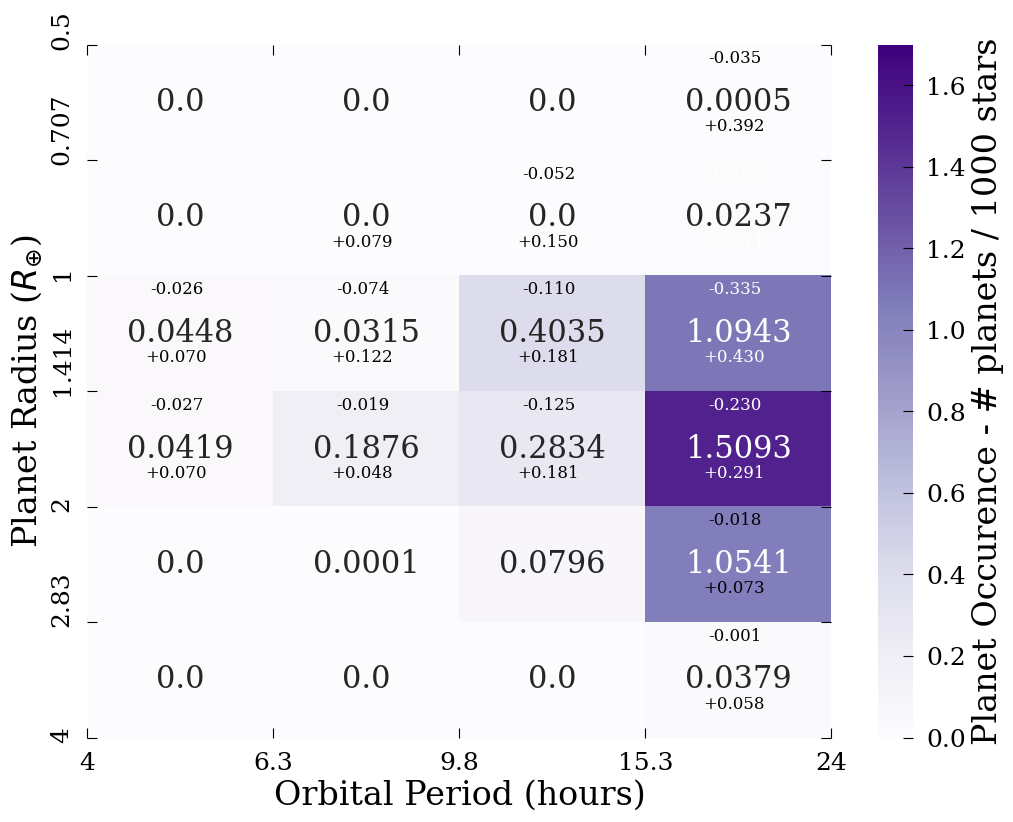

In [56]:
#labels = np.array([[0,0,0,0.0093],[0,0,0,0.0807],[0.0628,0.0238,0.3980,1.1387],[0.0595,0.2188,0.3398,1.6537],[0,0.0014,0.0676,1.1066],[0,0,0,0.0510]],dtype = object)
fig, ax = plt.subplots(figsize = (12, 9))
ax = sns.heatmap(1000*occur, annot = labels, fmt = '', annot_kws={"size": 22}, vmin=0, vmax=1.7, cmap = 'Purples')
for i in range(len(upper_labels)):
    for j in range(len(upper_labels[0])):
        color = 'k'
        if occur[i][j] * 1000 > 1:
            color = 'w'
        label = upper_labels[i][j]
        str_up_label = str(label) 
        if len(str_up_label) < 5:
            str_up_label += "0" 
        if label > 0:
            plt.text(0.31 + j, 5.75 - i, "+" + str_up_label, size = 12, color = color)
        down_label = lower_labels[i][j]
        str_down_label = str(down_label)
        if len(str_down_label) < 5:
            str_down_label += "0" 
        if down_label > 0:
            plt.text(0.34 + j, 5.16 - i, "-" + str_down_label, size = 12, color = color)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24])
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,0.707,1,1.414,2,2.83,4], horizontalalignment = 'right', verticalalignment = 'baseline')
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets / 1000 stars')
plt.xlabel("Orbital Period (hours)")
plt.ylabel("Planet Radius ($R_{\oplus}$)")

fig.savefig("OccurrenceRates.pdf", bbox_inches='tight')
plt.show()


## Mass Distribution

In [57]:
massbins = [0.5,1,2,4,8,16,32]
massbins2 = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2) ## twice as many mass bins
massbinsflip = np.flip(massbins,0)

mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)
mass_occur_earth2, mass_freq_earth2, mass_transit_earth2 = occur_freq_transit(earthmasssamples, persampleshours, massbins2, perbins)

mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)
mass_occur_merc2, mass_freq_merc2, mass_transit_merc2 = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)

# ## we should divide the contributions by 1000, because 1000 samples per planet
# ## but then we just multiply by 1000 again because per 1000 stars
# contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
# contribs2 = [1/1000 for i,j in enumerate(radiisamples)]
# mass_occur_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_occur_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# print("Occurrence rate array (Earth-like masses): (per thousand stars) \n", mass_occur_earth * 1000)

# mass_freq_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
# mass_freq_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# print("Frequency (Earth-like masses): \n", mass_freq_earth)

# ## we divide transit contributions by 1000 because 1000 planets per star
# transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
# mass_transit_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_transit_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# print("Transit array: (Earth-like masses)\n", mass_transit_earth)

# mass_occur_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)


# mass_occur_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# a, b, c = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)
# print(np.isclose(a, mass_occur_merc2))
# print(np.isclose(b, mass_freq_merc2))
# print(np.isclose(c, mass_transit_merc2))

In [58]:
mass_occur_earth_sum = np.flip((mass_occur_earth).sum(axis = 1))

## Tidal distortion masses

In [59]:
short_period_indices = []
for i, j in enumerate([p * 24 for p in per]):
    if j < 10:
        short_period_indices.append(i)

In [60]:
for i in short_period_indices:
    print(per[i]* 24, meanearthmasses[i])

4.736003999999999 5.168824796378507
8.52018072 2.3120408571304565
6.06134256 3.0520308329510675
7.343613840000001 2.0121632830965375
7.2384208800000005 3.838643788642237
8.460393360000001 1.7553477366471528
8.204208000000001 3.4988178543547526


Hi, it's much later. I've now gotten the samples.

In [61]:
distort_earthlike_samples = np.loadtxt("earthlike_distorted_samples_111820.txt")
distort_earthlike_samples =  10**distort_earthlike_samples
print(len(distort_earthlike_samples))
old_distort_earthlike_samples = 10**np.loadtxt("earthlike_distorted_samples_081120.txt")

7000


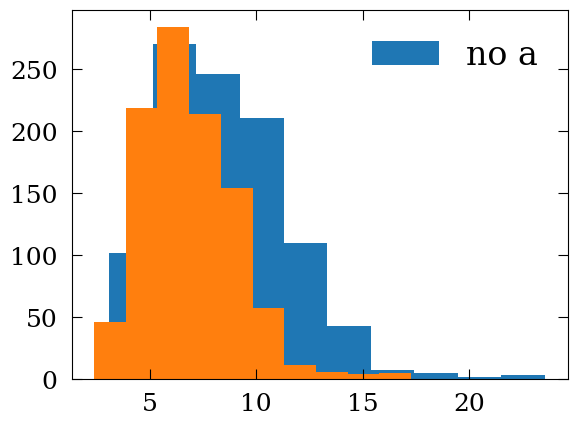

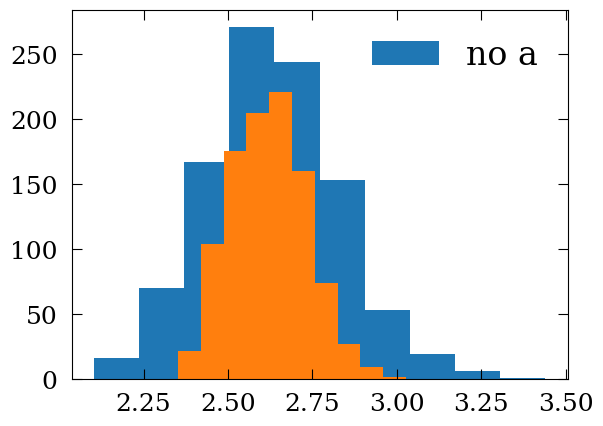

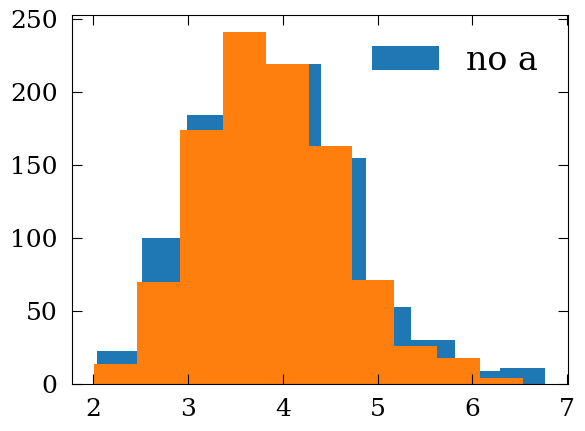

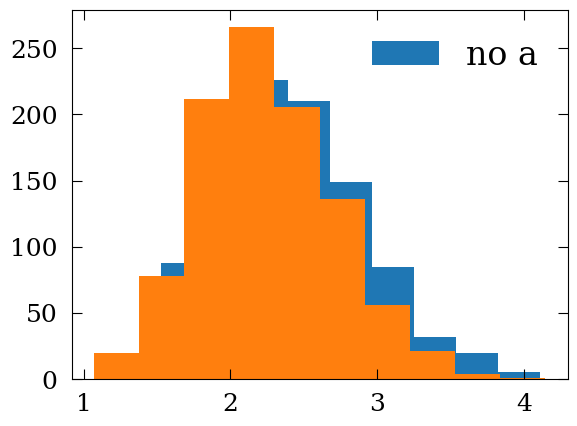

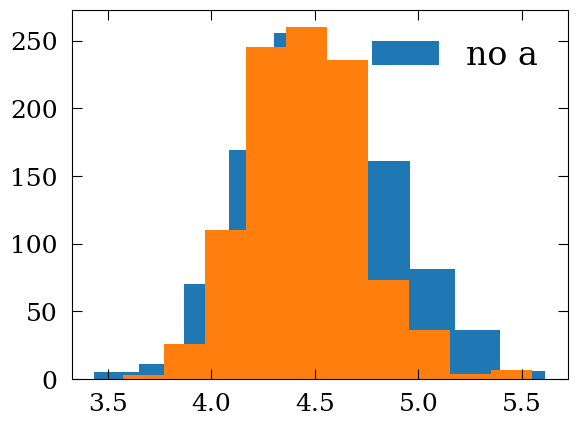

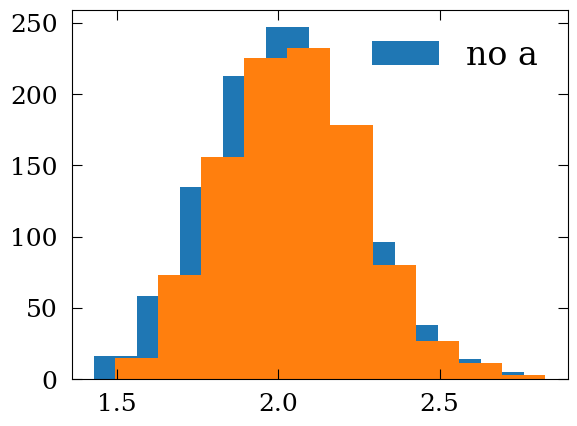

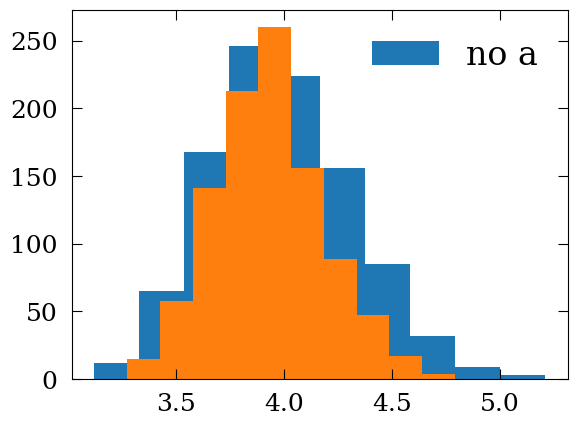

In [62]:
for i in range(7):
    plt.hist(distort_earthlike_samples[1000*i:1000*(i+1)], label = 'no a')
    plt.hist(old_distort_earthlike_samples[1000*i:1000*(i+1)])
    plt.legend()
    plt.show()

In [63]:
np.where(np.isnan(distort_earthlike_samples))
#plt.hist(old_distort_earthlike_samples[4000:5000])


(array([808]),)

In [64]:
distort_earthlike_samples[::1000]

array([9.973567  , 2.73959776, 5.45620917, 2.26196065, 4.50964754,
       1.61377199, 4.41495797])

In [65]:
import pandas as pd
df2 = pd.DataFrame()
spherical_samples = []
for index,value in enumerate(short_period_indices):
    spherical_samples.append(earthmasssamples[(1000*value) : (1000*(value+1))])
df2['distorted_sample'] = distort_earthlike_samples
df2['spherical_sample'] = np.array(spherical_samples).flatten()
periods = []
for i, j in enumerate(distort_earthlike_samples):
    periods.append(per[short_period_indices[i // 1000]])

In [66]:
len(periods)

7000

In [67]:
print(periods[999], periods[1001])

0.1973335 0.35500753


In [68]:
df2['period'] = [round(i * 24, 2) for i in periods]

In [69]:
for i in spherical_samples[2]:
    if i > 5:
        print(i)

5.043236941753608
5.264788148898989
5.056423512162042
5.22049301398478
5.135927613043123
5.10187518988576


Text(0, 0.5, 'Planet Mass ($M_{\\oplus}$)')

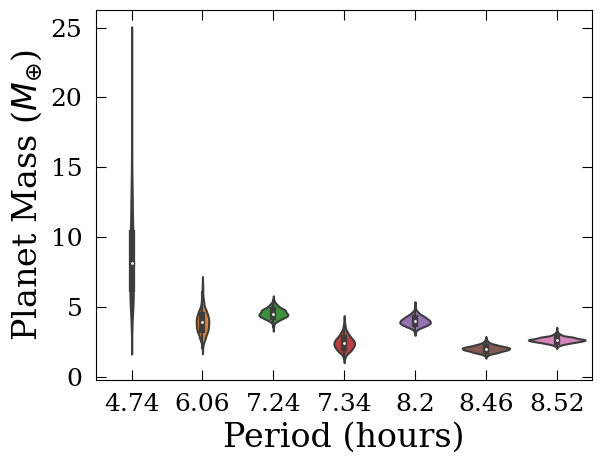

In [70]:
import seaborn as sns

sns.violinplot(x = df2['period'], y= df2['distorted_sample'])
plt.xlabel("Period (hours)")
plt.ylabel("Planet Mass ($M_{\oplus}$)")



In [71]:
short_period_indices

[0, 3, 4, 5, 6, 33, 55]

In [72]:
kic_per_dict = {}
for i in short_period_indices:
    print(24 * per[i], kepids[i])
    kic_per_dict[round(per[i]*24,2)] = kepids[i]

4.736003999999999 2718885
8.52018072 8435766
6.06134256 9642018
7.343613840000001 11187332
7.2384208800000005 11550689
8.460393360000001 9149789
8.204208000000001 8416523


In [73]:
kic_per_dict

{4.74: 2718885,
 8.52: 8435766,
 6.06: 9642018,
 7.34: 11187332,
 7.24: 11550689,
 8.46: 9149789,
 8.2: 8416523}

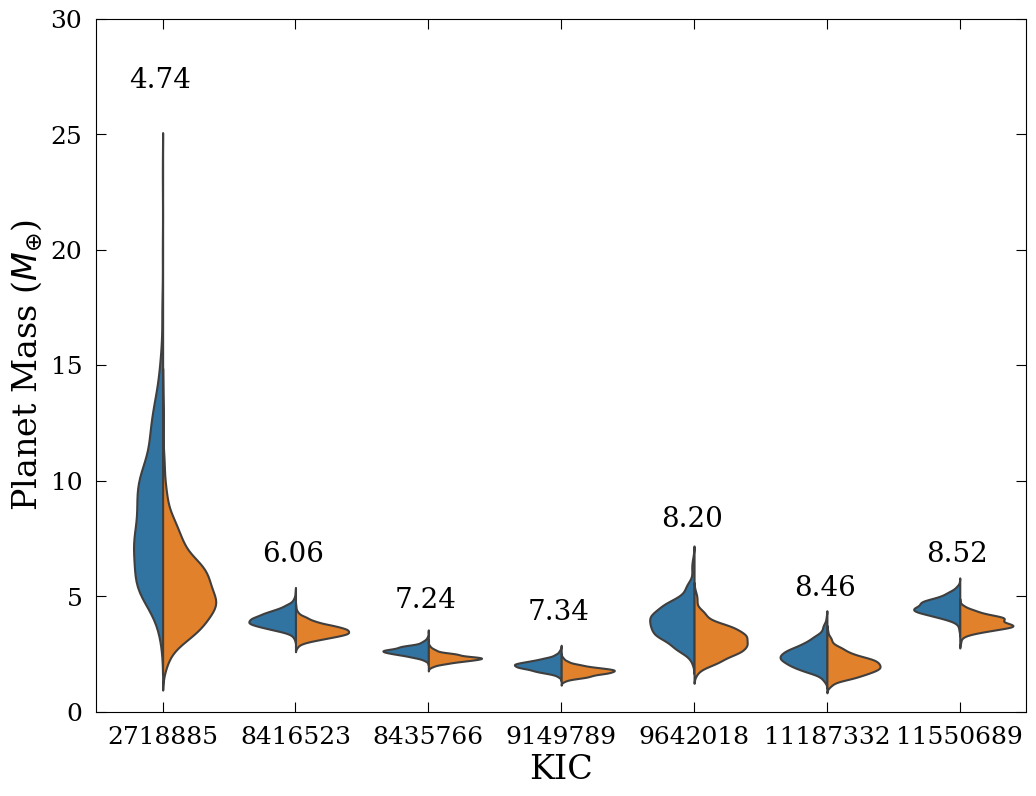

In [74]:
dumb_df = pd.DataFrame()
dumb_df['period'] = np.concatenate((df2.period.values, df2.period.values))
dumb_df['Sample Type'] = np.concatenate((['Distorted' for i in distort_earthlike_samples], ['Spherical' for i in df2.spherical_sample.values]))
dumb_df['Sample'] = np.concatenate((distort_earthlike_samples, df2.spherical_sample.values))
dumb_df['Log sample'] = np.log10(dumb_df.Sample.values)
dumb_df['KIC'] = [kic_per_dict[i] for i in dumb_df.period.values]

d = plt.figure(figsize = (12,9))
b = sns.violinplot(x = dumb_df['KIC'], y = dumb_df['Sample'], hue= dumb_df['Sample Type'], inner = None, split = True)
plt.xlabel("KIC")
plt.ylabel("Planet Mass ($M_{\oplus}$)")
#plt.title("Tidally distorted & spherical mass distributions")
plt.ylim(0, 30)
plt.text(-0.25, 27, '4.74', fontsize = 20)
plt.text(0.75, 6.5, '6.06', fontsize = 20)
plt.text(1.75, 4.5, '7.24', fontsize = 20)
plt.text(2.75, 4, '7.34', fontsize = 20)
plt.text(3.75, 8, '8.20', fontsize = 20)
plt.text(4.75, 5, '8.46', fontsize = 20)
plt.text(5.75, 6.5, '8.52', fontsize = 20)

b.legend_.remove()

plt.show()
d.savefig("DistortedDistributions.pdf", bbox_inches='tight')

In [75]:
distort_earth_masssamples = np.copy(earthmasssamples)

for index,value in enumerate(short_period_indices):
    print(index, value)
    for i, j in enumerate(distort_earth_masssamples[(1000*value) : (1000*(value+1))]):
        distort_earth_masssamples[(1000*value + i)] = distort_earthlike_samples[1000*index + i]
    

0 0
1 3
2 4
3 5
4 6
5 33
6 55


In [76]:
distort_earth_masssamples[3001]

2.6013145022574418

(array([ 16.,  70., 167., 271., 244., 153.,  53.,  19.,   6.,   1.]),
 array([2.10355462, 2.23710203, 2.37064945, 2.50419687, 2.63774428,
        2.7712917 , 2.90483912, 3.03838653, 3.17193395, 3.30548137,
        3.43902878]),
 <BarContainer object of 10 artists>)

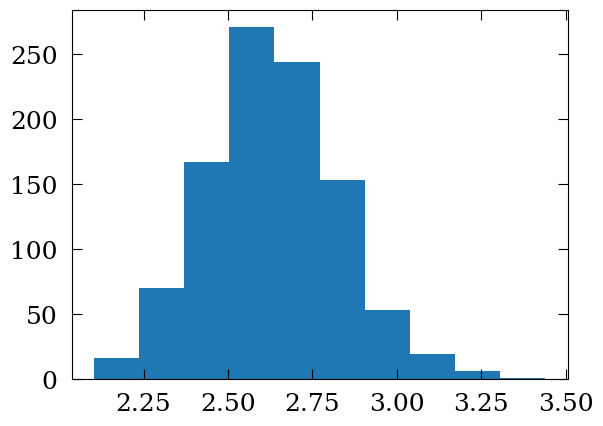

In [77]:
plt.hist(distort_earth_masssamples[3000:4000])

### Calculating uncertainties on earth-like mass distribution

In [78]:
upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)

# upper_earth = np.zeros_like(mass_occur_earth)
# lower_earth = np.zeros_like(mass_occur_earth)
# n_earth = mass_freq_earth / mass_transit_earth
# for i in range(len(mass_occur_earth)):
#     for j in range(len(mass_occur_earth[0])):
#         if np.isnan(n_earth[i][j]) == False:
#             p = mass_transit_earth[i][j]
#             root = ( (p * (1-p)) / n_earth[i][j]) ** 0.5
#             high = p + z * root
#             low  = p - z * root
#             upper_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*high * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000
#             lower_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*low * 1000

print("upper: \n", upper_earth)
print("actual: \n", mass_occur_earth * 1000)
print("lower: \n", lower_earth)

print(mass_occur_earth * 1000 - lower_earth)

upper: 
 [[0.         0.         0.         0.06590796]
 [0.04588895 0.         0.07232288 0.14039148]
 [0.06532344 0.03747635 0.16361154 0.25637185]
 [0.07248742 0.09838272 0.14701974 0.26632933]
 [0.04537917 0.09453297 0.15591923 0.40216055]
 [0.         0.         0.14508605 0.45381214]]
actual: 
 [[0.         0.         0.         0.01261343]
 [0.00325651 0.         0.03847568 0.19540934]
 [0.03402013 0.01154605 0.31108468 0.81872638]
 [0.04779281 0.13344623 0.18033534 0.70083218]
 [0.00166345 0.07420245 0.16867849 0.95516732]
 [0.         0.         0.06782627 0.62398063]]
lower: 
 [[0.         0.         0.         0.01058729]
 [0.00304073 0.         0.02511484 0.08169812]
 [0.02237011 0.00882668 0.1072226  0.19524449]
 [0.02880278 0.05663237 0.08099236 0.19299762]
 [0.00160463 0.04157193 0.08102579 0.28302079]
 [0.         0.         0.04621978 0.26274185]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.02614767e-03]
 [2.15782583e-04 0.00000000e+00 1.33608356e-02 1.13711223e-0

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Now I'm going to smush the grid into a 1d array, adding the errors in quadrature.

In [79]:
def smush_uncert(occur, upper, lower):
    occur_sum = np.flip((occur).sum(axis = 1))
    sum_upper = np.zeros_like(occur_sum)
    sum_lower = np.zeros_like(occur_sum)
    for i in range(len(occur)):
        errup = 0
        errdown = 0
        for j in upper[i]:
            errup += j**2
        for k in lower[i]:
            errdown += k**2
        sum_upper[i] = (errup**0.5)
        sum_lower[i] = (errdown**0.5)
    return occur_sum, sum_upper, sum_lower


mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)
print(mass_earth_sum_lower, mass_earth_sum_upper)

[0.01058729 0.08552534 0.22404337 0.21873424 0.2973159  0.26677621] [0.06590796 0.16445718 0.31331596 0.32784097 0.44389151 0.47644036]


In [80]:
# mass_occur_merc_sum = np.flip((mass_occur_merc).sum(axis = 1))

# upper_merc = np.zeros_like(mass_occur_merc)
# lower_merc = np.zeros_like(mass_occur_merc)
# n_merc = mass_freq_merc / mass_transit_merc
# for i in range(len(mass_occur_merc)):
#     for j in range(len(mass_occur_merc[0])):
#         if np.isnan(n_merc[i][j]) == False:
#             p = mass_transit_merc[i][j]
#             root = ((p * (1-p)) / n_merc[i][j] + (z**2)/(4*(n_merc[i][j]**2)))**0.5
#             denom = 1 + (z**2)/n_merc[i][j]
#             high = (p + (z**2)/(2*n_merc[i][j]) + z*root)/denom
#             low = (p + (z**2)/(2*n_merc[i][j]) - z*root)/denom
#             upper_merc[i][j] = 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*high - 1000*mass_occur_merc[i][j]
#             lower_merc[i][j] = 1000*mass_occur_merc[i][j] - 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*low
            
            
# print("upper: \n", upper_merc)
# #print("lower: \n", lower_merc)


upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)



# mass_merc_sum_upper = np.zeros_like(mass_occur_merc_sum)
# mass_merc_sum_lower = np.zeros_like(mass_occur_merc_sum)

# for i in range(len(n_merc)):
#     errup = 0
#     errdown = 0
#     for j in upper_merc[i]:
#         errup += j**2
#     for k in lower_merc[i]:
#         errdown += k**2
#     mass_merc_sum_upper[i] = (errup**0.5)
#     mass_merc_sum_lower[i] = (errdown**0.5)
    
    
mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)
# print(mass_merc_sum_lower, mass_merc_sum_upper)
# print(np.isclose(mu, mass_merc_sum_upper))
# print(np.isclose(ml, mass_merc_sum_lower))
# print(ml)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Mass Distribution Graph

In [81]:
x = 5

In [98]:
rand_array = []

nan_count = 0
for i in range(0, 50):
    
    randmasses = []
    print(i)
    for j, radsample in enumerate(radiisamples): 
        if j % 1000 == 0: ## use a different CMF for each planet
            randomcmf = np.random.normal(0.33,0.1)
            while (randomcmf <= 0):
                randomcmf = np.random.normal(0.33,0.1)
                
        try:
            randmasses.append(get_mass(radsample, randomcmf))
        except:
            #print("could not interpolate for sample", j, "cmf = ", randomcmf)
            if randomcmf < 0.1:
                randmasses.append(np.nan)
                nan_count += 1
            else:
                max_mass = get_max_mass_cmf(randomcmf)
                randmasses.append(max_mass)
                #print("max mass: ", max_mass)
            
#         try:
#             randmasses.append(get_mass(radsample, randomcmf))
#         except:
#             #print("could not interpolate for sample", j, "cmf = ", randomcmf)
#             randmasses.append(np.nan)
#     plt.hist(randmasses)
#     plt.show()
            
    rand_array.append(randmasses)

print(nan_count)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0


In [99]:
np.shape(rand_array)

(50, 58000)

In [100]:
contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]

In [101]:
def plot_mass_dist(massbins):
    
    mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)

    mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)

    upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)
    mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)

    upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)
    mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)
    
    ## adding tidally distorted masses
    mass_occur_distort, mass_freq_distort, mass_transit_distort = occur_freq_transit(distort_earth_masssamples, persampleshours, massbins, perbins)
    
    upper_distort, lower_distort = occur_uncert(mass_occur_distort, mass_freq_distort, mass_transit_distort)
    mass_occur_distort_sum, mass_distort_sum_upper, mass_distort_sum_lower =  smush_uncert(mass_occur_distort, upper_distort, lower_distort)


    massticks = np.zeros(len(massbins)-1) 
    for i in range(len(massbins)-1):
        massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)


    for i, j in enumerate(rand_array):
        
        mass_occur_rand = np.flip(np.histogram2d(j, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)

        mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
        plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
    plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
    plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
    plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
    plt.plot(massticks,mass_occur_distort_sum * 1000, label = 'With Earth-like distorted planets', linewidth = 2.5, color = 'tab:red')
#     plt.errorbar(massticks,mass_occur_earth_sum * 1000, yerr = np.stack((mass_earth_sum_lower,mass_earth_sum_upper)), linestyle = 'None', ecolor = 'tab:blue', capsize = 6)
#     plt.errorbar(massticks,mass_occur_merc_sum * 1000, yerr = np.stack((mass_merc_sum_lower,mass_merc_sum_upper)), linestyle = 'None', ecolor = 'tab:orange', capsize = 6)
    plt.fill_between(massticks, mass_occur_earth_sum * 1000 + mass_earth_sum_upper,  mass_occur_earth_sum * 1000 - mass_earth_sum_lower, alpha = 0.2)
    plt.fill_between(massticks, mass_occur_merc_sum * 1000 + mass_merc_sum_upper,  mass_occur_merc_sum * 1000 - mass_merc_sum_lower, alpha = 0.2)
    
    plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
    plt.xlabel('Planet Mass ($M_{ \oplus}$)')
    plt.ylabel('Number of planets per thousand stars')
    plt.ylim(0, 1.6)
    plt.legend()
    plt.show()

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


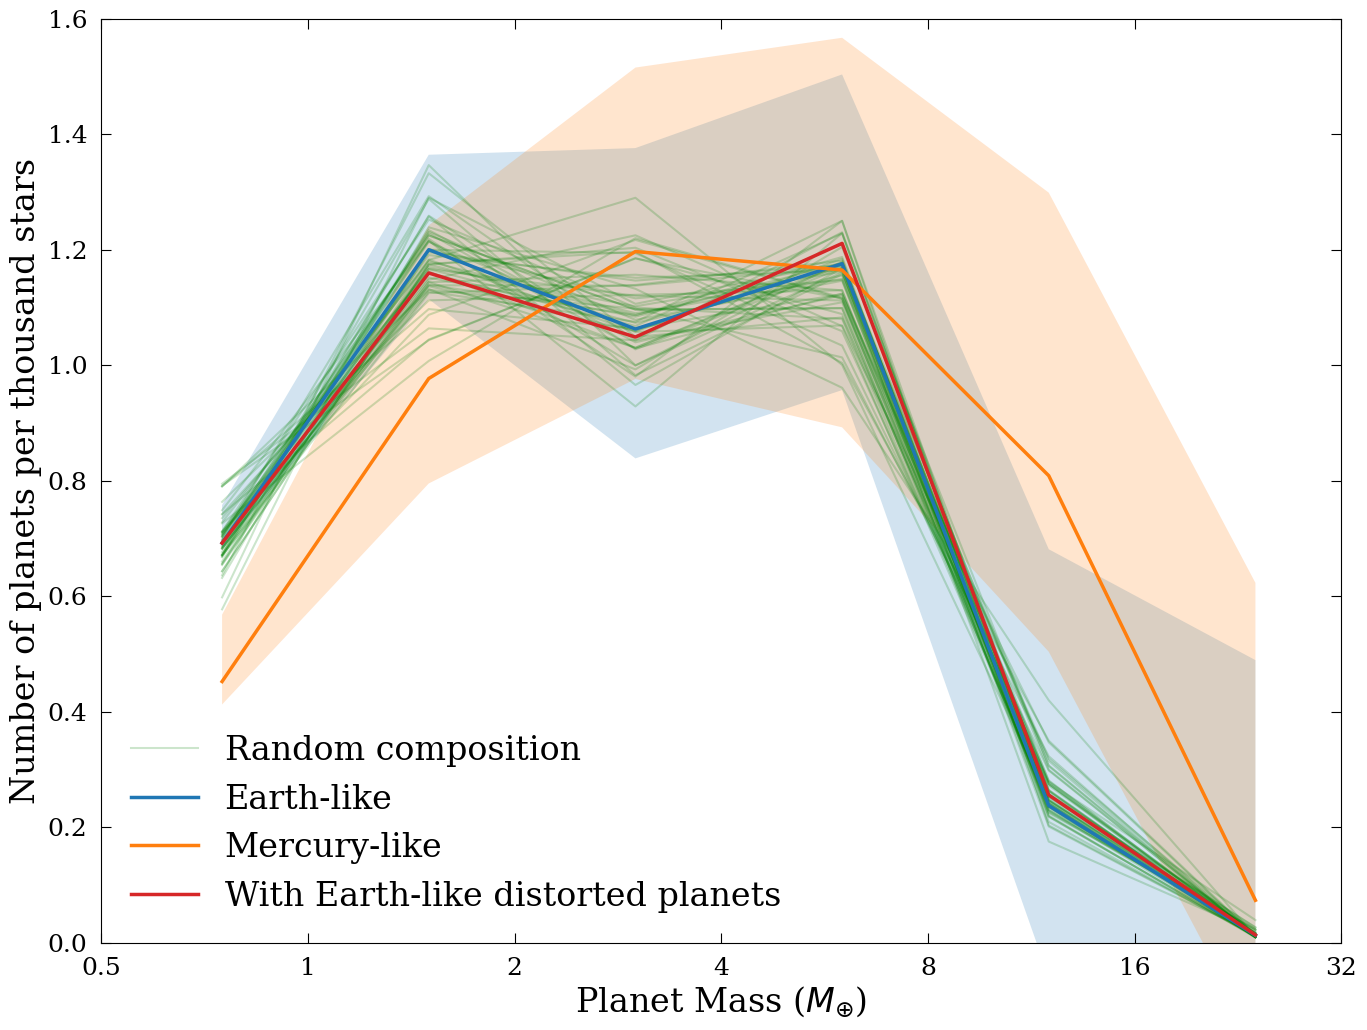

In [ ]:
mass_fig = plt.figure(figsize = (16,12))
plot_mass_dist(massbins)
mass_fig.savefig("MassDistribution.pdf", bbox_inches = "tight")

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


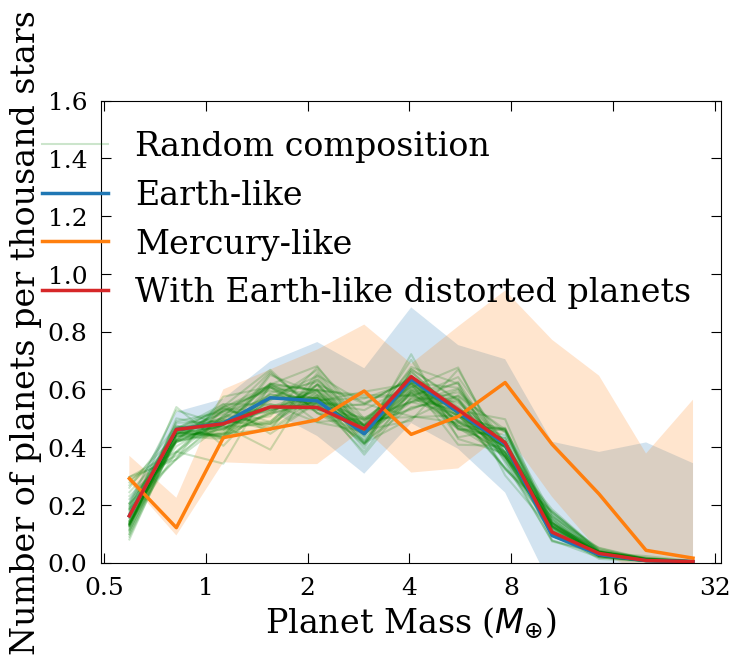

In [1062]:
plot_mass_dist(massbins2)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


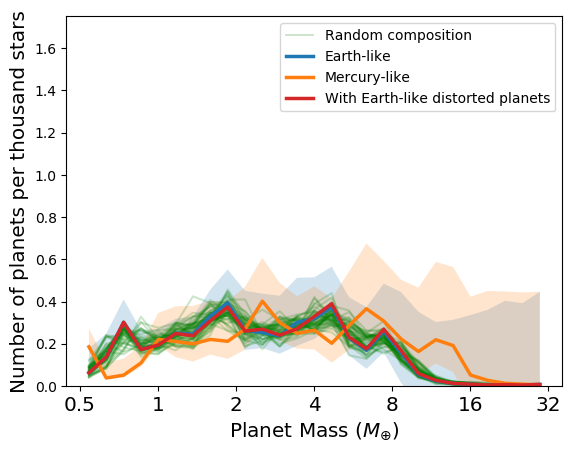

In [506]:
plot_mass_dist(np.logspace(np.log2(0.5), np.log2(32), 28, base = 2))

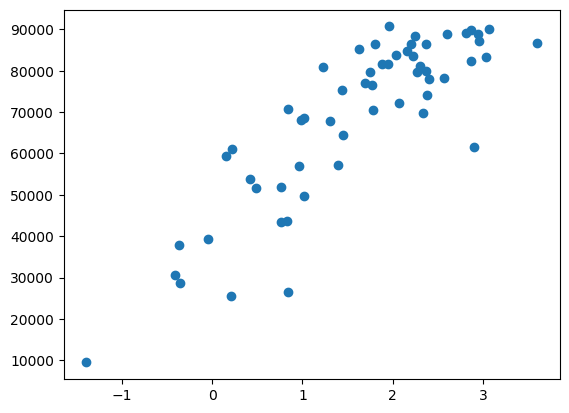

In [724]:
plt.plot(np.log2(meanearthmasses), numstars, 'o')


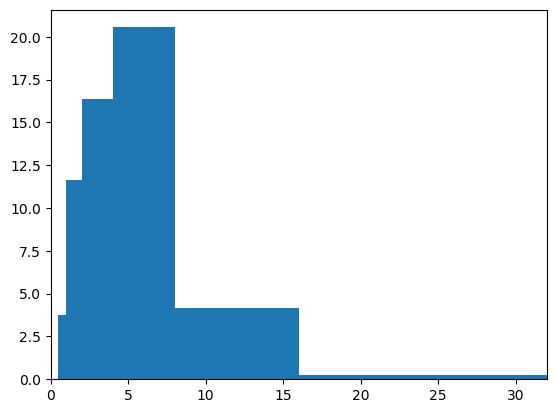

In [725]:
plt.hist(earthmasssamples, bins = massbins, weights = contribs2)
plt.xlim(0,32)
plt.show()

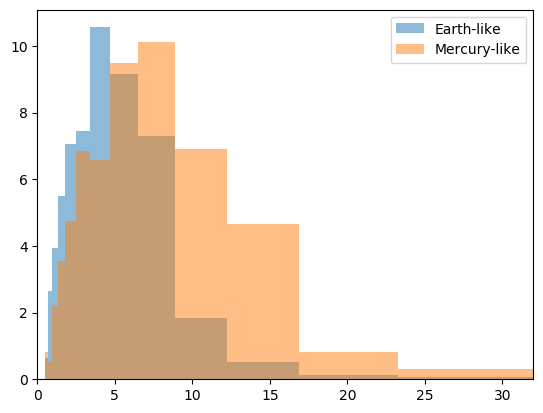

In [726]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2, alpha = 0.5, label = "Earth-like")
plt.hist(mercurymasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2,  alpha = 0.5, label = "Mercury-like")
plt.legend()
plt.xlim(0,32)
plt.show()

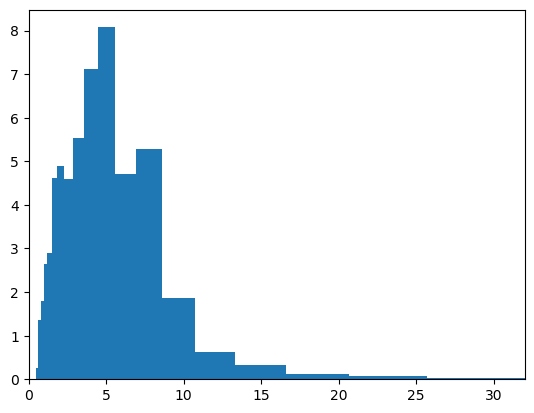

In [727]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 20, base = 2), weights = contribs2)
plt.xlim(0,32)
plt.show()

## Incorporating Measured Masses

I'm going to incorporate measured masses for Kepler-10b and Kepler-78b. For Kepler-10b, the measured mass is 3.72 +/- 0.42 Earth masses. For Kepler-78b, the measured mass is 1.82 +/- 0.27 

Kepler-78b mass: https://ui.adsabs.harvard.edu/abs/2015ESS.....311305G/abstract

Kepler-10b mass: https://arxiv.org/abs/1601.06168

In [1072]:
list(kepids).index(11600889)

47

(array([ 25., 111., 295., 300., 171.,  72.,  18.,   6.,   1.,   1.]),
 array([3.81294697, 4.23910858, 4.66527019, 5.09143181, 5.51759342,
        5.94375504, 6.36991665, 6.79607827, 7.22223988, 7.64840149,
        8.07456311]),
 <a list of 10 Patch objects>)

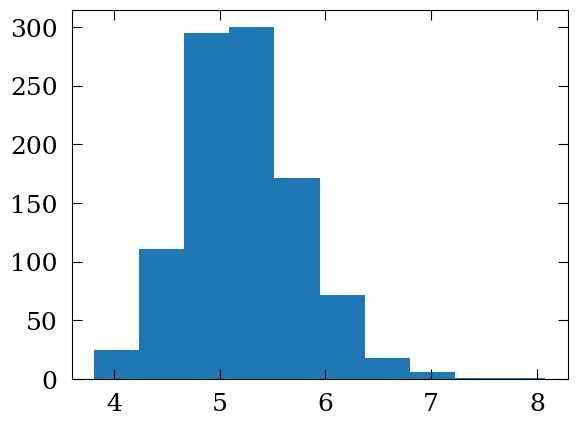

In [1073]:
plt.hist(earthmasssamples[50000:51000])

In [1074]:
import scipy.stats
dist10 = scipy.stats.norm(3.72, 0.42)
dist78 = scipy.stats.norm(1.77, 0.25)

In [1075]:
list(kepids).index(11904151) ## Kepler-10

50

In [1076]:
f[53]

6.101919029498206e-05

In [1077]:
list(kepids).index(8435766) ## Kepler-78

3

In [1078]:
f[3]

4.160966949688843e-05

In [1079]:
len(radiisamples)

58000

In [1080]:
kep10_earthsamples = earthmasssamples[53 * 1000: 54 * 1000]
kep78_earthsamples = earthmasssamples[3 * 1000: 4 * 1000]
kep10_mercsamples = mercurymasssamples[53 * 1000: 54 * 1000]
kep78_mercsamples = mercurymasssamples[3 * 1000: 4 * 1000]

We are calculating a normalization factor as follows:
$ n = \frac{\sum{f}}{\sum{f * pdf(m)}}$

where f is the occurrence rate contribution and pdf(m) is the probability of getting that mass.

In [1081]:
print("Kepler-10 measured mass: 3.72 +/- 0.42")
print(np.average(kep10_earthsamples), np.std(kep10_earthsamples))
print(np.average(kep10_mercsamples), np.std(kep10_mercsamples))


print("Kepler-78b measured mass: 1.77 +/- 0.25")
print(np.average(kep78_earthsamples), np.std(kep78_earthsamples))

Kepler-10 measured mass: 3.72 +/- 0.42
3.792858413073081 0.44940299294086233
5.876057884800757 0.7296741570599639
Kepler-78b measured mass: 1.77 +/- 0.25
2.3172466720220344 0.17472602235678295


In [1082]:
kep10_radiisamples = radiisamples[53 * 1000: 54 * 1000]
kep78_radiisamples = radiisamples[3 * 1000: 4 * 1000]

print("Kepler-10 measured radius: 1.47")
print(np.average(kep10_radiisamples), np.std(kep10_radiisamples))

print("Kepler-10 measured radius: 1.2")
print(np.average(kep78_radiisamples), np.std(kep78_radiisamples))

Kepler-10 measured radius: 1.47
1.429022686017939 0.04531322507304021
Kepler-10 measured radius: 1.2
1.250990871568691 0.025763344633113076


(array([ 16.,  74., 172., 260., 242., 157.,  55.,  17.,   6.,   1.]),
 array([1.84371943, 1.96339077, 2.08306211, 2.20273345, 2.32240479,
        2.44207613, 2.56174747, 2.68141882, 2.80109016, 2.9207615 ,
        3.04043284]),
 <a list of 10 Patch objects>)

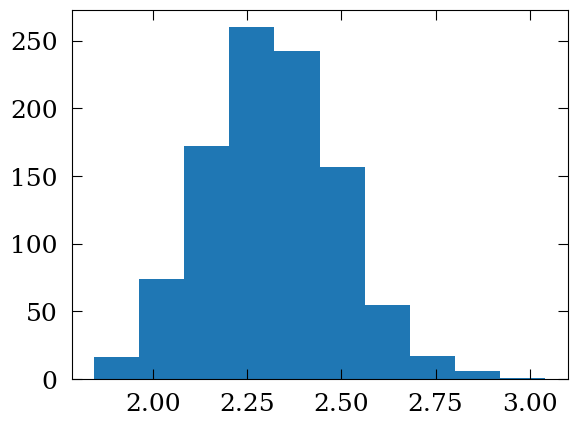

In [1083]:
plt.hist(kep78_earthsamples)

In [1084]:
sum_contribs_10 = 0
sum_contribs_78 = 0
sum_weighted_10 = 0
sum_weighted_78 = 0
for i,j in zip(kep10_earthsamples, kep78_earthsamples):
    sum_contribs_10 += f[53]
    sum_contribs_78 += f[3]
    sum_weighted_10 += f[53]*dist10.pdf(i)
    sum_weighted_78 += f[3]*dist78.pdf(j)

earth10norm = sum_contribs_10 / sum_weighted_10
earth78norm = sum_contribs_78 / sum_weighted_78
print(earth10norm, earth78norm)    
    

1.5459460115142392 3.8420033569003764


In [1085]:
sum_contribs_10 = 0
sum_contribs_78 = 0
sum_weighted_10 = 0
sum_weighted_78 = 0
for i,j in zip(kep10_mercsamples, kep78_mercsamples):
    sum_contribs_10 += f[53]
    sum_contribs_78 += f[3]
    sum_weighted_10 += f[53]*dist10.pdf(i)
    sum_weighted_78 += f[3]*dist78.pdf(j)

merc10norm = sum_contribs_10 / sum_weighted_10
merc78norm = sum_contribs_78 / sum_weighted_78
    
print(merc10norm, merc78norm)  

79.83689165820732 574049.3734874929


Now, I will re-calculate the ocurrence rates in the mass bins, but the occurrence rate contribution for each mass sample will be: $f * n * pdf(m)$

In [1086]:
f[3]

4.160966949688843e-05

In [1087]:
f[3] * dist78.pdf(earthmasssamples[3100]) * earth78norm

0.00018878410795053387

In [1088]:
contribs = [(f[i//1000])/1000 for i,j in enumerate(earthmasssamples)]
earth_measured_contribs = np.copy(contribs)
for i, j in enumerate(contribs[(1000*3) : (1000*(4))]):
    if i % 100 == 0:
        print(earth_measured_contribs[(1000*3 + i)])
    earth_measured_contribs[(1000*3 + i)] = f[3] / 1000 * dist78.pdf(earthmasssamples[(1000*3 + i)]) * earth78norm
    if i % 100 == 0:
        print(earth_measured_contribs[(1000*3 + i)])
for i, j in enumerate(contribs[(1000*53) : (1000*(54))]):
    earth_measured_contribs[(1000*53 + i)] = f[53] / 1000 * dist10.pdf(earthmasssamples[(1000*53 + i)]) * earth10norm

merc_measured_contribs = np.copy(contribs)
for i, j in enumerate(contribs[(1000*3) : (1000*(4))]):
    merc_measured_contribs[(1000*3 + i)] = f[3] / 1000 * dist78.pdf(mercurymasssamples[(1000*3 + i)]) * merc78norm
for i, j in enumerate(contribs[(1000*53) : (1000*(54))]):
    merc_measured_contribs[(1000*53 + i)] = f[53] / 1000 * dist10.pdf(mercurymasssamples[(1000*53 + i)]) * merc10norm
    

def occur_freq_transit_measured(contribs, masssamples, persampleshours, massbins, perbins):

    contribs2 = [1/1000 for i,j in enumerate(masssamples)]
    occur = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)
    freq = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
    transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
    transit = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                                       weights = transit_contribs)[0], 0)
    return occur, freq, transit

4.160966949688843e-08
8.922251669428881e-09
4.160966949688843e-08
1.8878410795053386e-07
4.160966949688843e-08
6.533706406975772e-08
4.160966949688843e-08
2.4494874173123385e-10
4.160966949688843e-08
1.5473360736975503e-08
4.160966949688843e-08
2.3300876746258253e-08
4.160966949688843e-08
6.211621276904083e-08
4.160966949688843e-08
2.6021023704206708e-08
4.160966949688843e-08
8.193927381958355e-08
4.160966949688843e-08
4.585414669961974e-08


In [1089]:
kep10_samples = np.random.normal(3.72, 0.42, 1000)
kep78_samples = np.random.normal(1.77, 0.25, 1000)

In [1090]:
measured_samples_no_weighting_earth = np.copy(earthmasssamples)
measured_samples_no_weighting_earth[53 * 1000: 54 * 1000] = kep10_samples
measured_samples_no_weighting_earth[3 * 1000: 4 * 1000] = kep78_samples

measured_samples_no_weighting_merc = np.copy(mercurymasssamples)
measured_samples_no_weighting_merc[53 * 1000: 54 * 1000] = kep10_samples
measured_samples_no_weighting_merc[3 * 1000: 4 * 1000] = kep78_samples

In [1091]:
def get_graph_arrays(masssamples, persamples = persampleshours, massbins = massbins, perbins = perbins):
    mass_occur, mass_freq, mass_transit = occur_freq_transit(masssamples, persamples, massbins, perbins)
    upper, lower = occur_uncert(mass_occur, mass_freq, mass_transit)
    mass_occur_sum, mass_sum_upper, mass_sum_lower =  smush_uncert(mass_occur, upper, lower)
    return mass_occur_sum, mass_sum_upper, mass_sum_lower

In [1092]:
def get_graph_arrays_measured(contribs, masssamples, persamples = persampleshours, massbins = massbins, perbins = perbins):
    mass_occur, mass_freq, mass_transit = occur_freq_transit_measured(contribs, masssamples, persamples, massbins, perbins)
    upper, lower = occur_uncert(mass_occur, mass_freq, mass_transit)
    mass_occur_sum, mass_sum_upper, mass_sum_lower =  smush_uncert(mass_occur, upper, lower)
    return mass_occur_sum, mass_sum_upper, mass_sum_lower

In [1095]:
def plot_mass_dist_w_measured(massbins):

    mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  get_graph_arrays(earthmasssamples)
    mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  get_graph_arrays(mercurymasssamples)
    
    ## adding measured masses
    ## weighting mass samples according to measured masses
    mass_occur_e_measure_sum, mass_e_measure_sum_upper, mass_e_measure_sum_lower =  get_graph_arrays_measured(earth_measured_contribs, earthmasssamples)
    mass_occur_m_measure_sum, mass_m_measure_sum_upper, mass_m_measure_sum_lower =  get_graph_arrays_measured(merc_measured_contribs, mercurymasssamples)
    
    ## replacing mass samples with samples from measured distribution
    mass_measure_sum_e, mass_measure_sum_e_upper, mass_measure_sum_e_lower = get_graph_arrays(measured_samples_no_weighting_earth)
    mass_measure_sum_m, mass_measure_sum_e_upper, mass_measure_sum_m_lower = get_graph_arrays(measured_samples_no_weighting_merc)


    ## adding tidally distorted masses
    mass_occur_distort_sum, mass_distort_sum_upper, mass_distort_sum_lower =  get_graph_arrays(distort_earth_masssamples)


    massticks = np.zeros(len(massbins)-1) 
    for i in range(len(massbins)-1):
        massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)

    ## plot random mass distributions
    for i, j in enumerate(rand_array):
        mass_occur_rand = np.flip(np.histogram2d(j, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)

        mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
        plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
    plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
    
    ## plot measured masses
    plt.plot(massticks,mass_measure_sum_m * 1000, linewidth = 2.5, color = 'tab:orange', linestyle='dashed')
    plt.plot(massticks,mass_measure_sum_e * 1000, linewidth = 2.5, color = 'tab:blue', linestyle='dashed')

    ## plot other distributions
    plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
    plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
    plt.plot(massticks,mass_occur_distort_sum * 1000, label = 'With Earth-like distorted planets', linewidth = 2.5, color = 'tab:red')

    ## plot fake gray dashed line just to get it on the legend
    plt.plot(massticks, -1 * np.ones_like(mass_measure_sum_e), label = 'Incorporating measured masses', linewidth = 2.5, color = 'tab:gray', linestyle='dashed')
    
    ## error shading
    plt.fill_between(massticks, mass_occur_earth_sum * 1000 + mass_earth_sum_upper,  mass_occur_earth_sum * 1000 - mass_earth_sum_lower, alpha = 0.2)
    plt.fill_between(massticks, mass_occur_merc_sum * 1000 + mass_merc_sum_upper,  mass_occur_merc_sum * 1000 - mass_merc_sum_lower, alpha = 0.2)
    
    plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
    plt.xlabel('Planet Mass ($M_{ \oplus}$)')
    plt.ylabel('Number of planets per thousand stars')
    plt.ylim(0, 1.6)
    plt.legend(loc = 'lower left')
    plt.show()

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


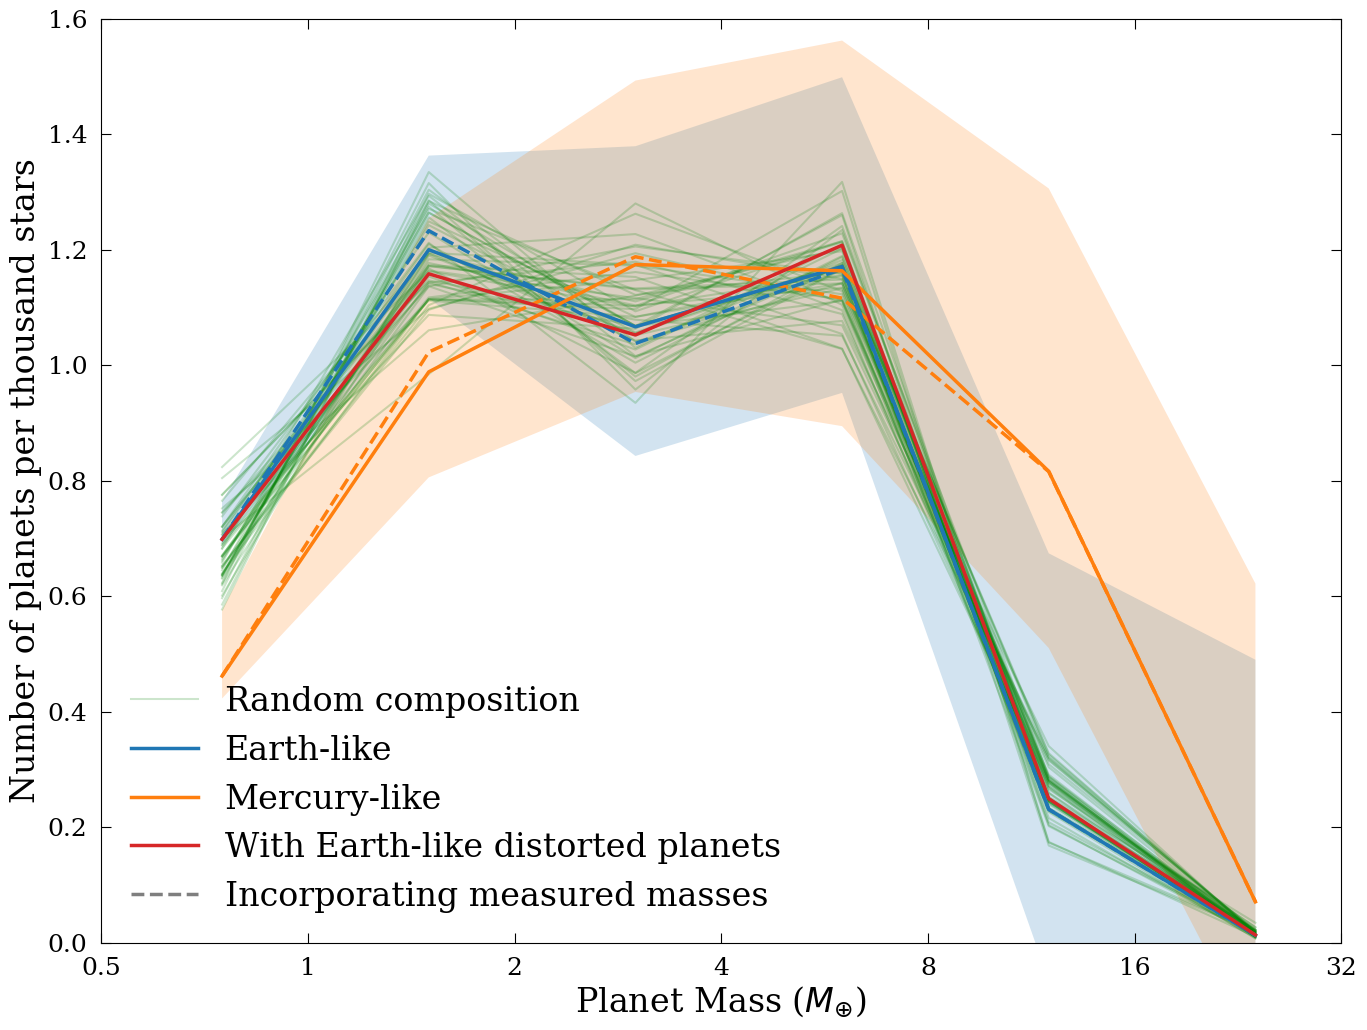

In [1096]:
q = plt.figure(figsize = (16,12))
plot_mass_dist_w_measured(massbins)

q.savefig("MassDistributionFinal.pdf", bbox_inches='tight')